## Tests for *fpcross* module

> Cross approximation of the solution of the Fokker-Planck equation.

---
---

### Algorithm

> This is a draft of the algorithm. which is used in Solver module/class (Russian is used for simplicity).

**Задача:** найти PDF $\rho$ в момент времени $t$ на Чебышевской сетке из уравнений
$$
    dx = f(x, t) \, dt + d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ f(x, t) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x).
$$

**Нужно** передать в крест (tt-cross) функцию (step), которая вычисляет значения $\rho_{k+1}$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки. Это позволит проинтерполировать $\rho$ на $(k+1)$-ом шаге и перейти к следующему шагу. При этом предполагается, что интерполянт для $k$-ого шага уже известен.

> На нулевом шаге имеем $\rho_0(x)$, заданную как функцию от $x$ и можем построить интерполянт очевидным образом.

> Если не используем крест (работаем в полном numpy формате), то $X$ - это полный набор точек Чебышевской сетки (алгоритм при этом остается прежним).

> Алгоритм расписан для splitting схемы первого порядка, поэтому для решения ОДЕ можем использовать метод Эйлера без потери точности.

**Работа функции step(X, I)**

> X - произвольный набор точек Чебышевской сетки (ndarray [dims, pois] of float)

> I - набор индексов узлов сетки, соответствующий точкам X (ndarray [dims, pois] of int)

**1** Найти прообразы $\widehat{X}$ (соответствуют предыдущему $k$-ому шагу) для заданного набора точек $X$ Чебышевской сетки, которые приводили бы траекторию детерминированного уравнения ($\beta = 0$) в точки $X$ на $(k+1)$-ом шаге, интегрируя назад уравнение
$$
    \frac{\partial \, x}{\partial \, t} = f(x, t),
    \quad
    x_{k+1} = X,
    \quad
    x_{k} = \widehat{X} = ?,
$$
используя формулу Эйлера
$$
    \widehat{X} = X - h \cdot f(X, t_k).
$$

**2** Используя известный интерполянт на $k$-ом шаге, вычислить значения PDF $\widehat{\rho}$ в точках $\widehat{X}$.

**3** Положить нулевое значение для $\widehat{\rho}$ в тех точках из $\widehat{X}$, которые оказались вне пределов интерполяции.

**4** Решить PDE с однородными граничными условиями Дирихле для $(k+1)$-ого шага
$$
    \frac{\partial v}{\partial t} = \Delta v,
    \quad
    v_{k} = \widehat{\rho},
    \quad
    v_{k+1} = v = ?,
$$
используя дифференциальную матрицу Чебышева
$$
v = e^h \left( e^D \otimes \ldots \otimes e^D \right) \widehat{\rho},
$$

**5** Решить ODE для $k+1$-ого шага
$$
    \frac{\partial \, \log{w}}{\partial \, t} = -tr \left[ f_x(x, t) \right],
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = w = ?,
$$
используя формулу Эйлера
$$
    \log{w} =
        \log{\widehat{\rho}} -
        h \cdot tr \left[ \frac{\partial \, f}{\partial \, x}(\widehat{X}, t_k) \right].
$$

**6** Вернуть значение $w$ как приближение $\rho(x)$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки на $(k+1)$-ом шаге.

In [1]:
import sys
import time

import numpy as np


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from IPython.display import HTML

sys.path.append('./../lib')
from intertrain import Intertrain
from solver import Solver

---
---

### Solution of 1D Ornstein–Uhlenbeck process

Ornstein–Uhlenbeck process
$$
    \frac{d \, x}{d \, t} = - \lambda x(t) + w(t),
    \quad
    x(0) = x_0,
    \quad
    \lambda > 0,
$$
or
$$
    d \, x = - \lambda x(t) d \, t + d \, \beta(t),
    \quad
    x(0) = x_0,
    \quad
    \lambda > 0,
$$

Its solution is
$$
    x(t) = e^{-\lambda t} x(0) + \int_0^t e^{-\lambda (t - \tau)} d \, \beta(\tau),
$$
and covariance matrix is
$$
    C(t) = \frac{q}{2\lambda} e^{-\lambda |t|},
$$
where $q$ is spectral density of the one dimensional white noise process $w(t)$.

The probability density function (PDF) $\rho(x, t)$ satisfies the Fokker–Planck equation
$$
   \frac{\partial \, \rho}{\partial \, t} =
       \lambda \frac{\partial}{\partial \, x} (x \rho) +
       \frac{1}{2} \frac{\partial^2 \, \rho}{\partial \, x^2},
$$
with transition probability
$$
    \rho(x, t | x_0, t_0=0) = 
        \sqrt{
            \frac{\lambda}{\pi \left( 1 - e^{-2 \lambda t} \right)}
        }
        e^{\frac
            {-\lambda \left( x - x_0 e^{-\lambda t} \right)^2}
            {1 - e^{-2 \lambda t}}
        }.
$$

**Примечание** Transition probability не может использоваться как корректное значение для сравнения, поскольку она зависит от начальной точки пространственной траектории!!

In [2]:
# SDE parameters : f = A x, df / dx = A (dimension = 1)

A = 1.

def func_f(x):
    return A*x

def func_f_der(x):
    return A*np.ones(x.shape)

def func_r0(x):
    s = 1.0
    m = 0.
    r = 1./np.sqrt(2.*np.pi * s**2)
    r*= np.exp(-1. * (x-m)**2 / 2. / s**2)
    return r.reshape(-1)

def func_r(x, t, x0):
    l = -1. * A
    e = np.exp(-1. * l * t)
    r = np.sqrt(l / np.pi /  (1. - e*e))
    r*= np.exp(-1. * l * (x - x0 * e)**2 / (1. - e*e))
    return r

Info
--- Time grid
Time points : 5
Time min    : 0.00e+00
Time max    : 1.00e+00
--- Time
Prep        : 2.88e-03 sec. 
Calc        : 3.31e-03 sec. 
Info from Intertrain
------------------ Parameters
Format           : NP
Dimensions       :        1
Dim 1  | Poi 10  | Min -3.000 | Max 3.000  |
------------------ Time
Init             : 5.63e-04 sec. 
Prep             : 1.11e-04 sec. 
Calc (average)   : 0.00e+00 sec. 
Func (average)   : 5.62e-05 sec. 
------------------ Test (random points)
Number of points : 10
Error (max)      :      inf 
Error (mean)     :      inf 
Error (min)      : 7.74e-02 
------------------


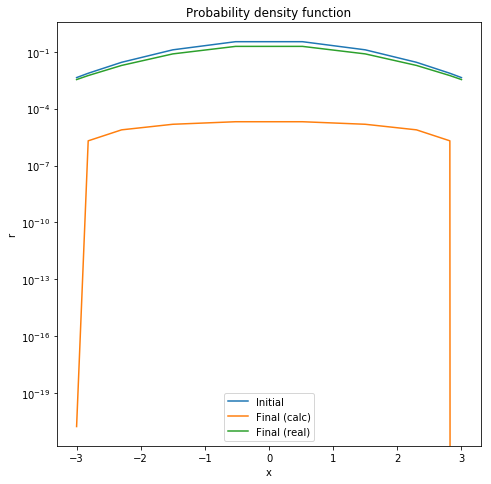

In [5]:
SL = Solver(d=1, with_tt=False)
SL.set_grid_t(5)
SL.set_grid_x(10)
SL.set_funcs(func_f, func_f_der, func_r0, func_r)
SL.prep()
SL.calc()
SL.info()
SL.plot()

---
---